In [1]:
import numpy as np
np.set_printoptions(suppress=True)

In [2]:
from pyomo.environ import *

### Read input data

In [3]:
mat_alpha = np.genfromtxt('input_csv/mat_alpha.csv', delimiter=',')
mat_alpha_sector_mean = np.genfromtxt('input_csv/mat_alpha_sector_mean.csv', delimiter=',')
mat_emissions = np.genfromtxt('input_csv/mat_emissions.csv', delimiter=',')
mat_emissions_country_totals = np.genfromtxt('input_csv/mat_emissions_country_totals.csv', delimiter=',')
mat_emissions_sector_mean = np.genfromtxt('input_csv/mat_emissions_sector_mean.csv', delimiter=',')
mat_emissions_sector_totals = np.genfromtxt('input_csv/mat_emissions_sector_totals.csv', delimiter=',')
mat_intensities = np.genfromtxt('input_csv/mat_intensities.csv', delimiter=',')
mat_proxy = np.genfromtxt('input_csv/mat_proxy.csv', delimiter=',')

In [4]:
n_countries, n_sectors = mat_proxy.shape

### Generate constants

In [5]:
# Get row and column indices of NAN values in alpha (decision variables)
irows, icols = np.where(np.isnan(mat_alpha))
print(irows.shape[0])
print(icols.shape[0])

4408
4408


In [6]:
# Generate some helper matrices
mat_intensities_stacked = np.tile(mat_intensities, (n_countries, 1))
mat_alpha_sector_mean_stacked = np.tile(mat_alpha_sector_mean, (n_countries, 1))
mat_estimated_emissions = np.multiply(np.multiply(mat_proxy, mat_intensities_stacked), mat_alpha)

In [7]:
const_estimated_emissions_country_total = np.nansum(mat_estimated_emissions, axis= 1)
const_estimated_emissions_sector_total = np.nansum(mat_estimated_emissions, axis= 0)

In [8]:
# To initialize decision variables, fill alpha matrix nan with sector means
mat_alpha_filled = mat_alpha.copy()
mat_alpha_filled[irows, icols] = mat_alpha_sector_mean_stacked[irows, icols]

### Create model

In [ ]:
mo = ConcreteModel()

### Create sets

In [ ]:
mo.C = Set(initialize=range(n_countries), ordered=True)
mo.S = Set(initialize=range(n_sectors), ordered=True)

In [ ]:
#mo.pprint()

### Create decision variables

In [ ]:
import random
def x_init(mo, c, s):
    return mat_alpha_filled[c, s]# * (1 + 0.2 * random.random())
mo.X = Var(mo.C, mo.S, within=NonNegativeReals, initialize=x_init)

In [ ]:
#mo.X.pprint()

### Create objective function

In [ ]:
def objective_function_rule(mo):
    return sum((sum(mo.X[c,s] * mat_intensities_stacked[c,s] * mat_proxy[c,s] for s in mo.S) - mat_emissions_country_totals[c])**2 for c in mo.C)\
            + sum((sum(mo.X[c,s] * mat_intensities_stacked[c,s] * mat_proxy[c,s] for c in mo.C) - mat_emissions_sector_totals[s])**2 for s in mo.S)
mo.obj = Objective(sense=minimize, rule=objective_function_rule)

In [ ]:
#mo.obj.pprint()

### C1: Non - zero
Included in DV definition

### C2: Fix alphas that are not nan

In [ ]:
mo.c_fix_nonnan = ConstraintList()
for c in mo.C:
    for s in mo.S:
        if not np.isnan(mat_alpha[c,s]):
            mo.c_fix_nonnan.add(expr=mo.X[c,s]==mat_alpha[c,s])

### Solve

In [ ]:
#with open('logs/opti_model.txt', 'w') as f:
#    mo.pprint(ostream=f)

In [ ]:
solver_path = r'..\_Solvers\Ipopt-3.11.1-win64-intel13.1\bin\ipopt.exe'

In [ ]:
multistart = False

print('--- start solver ---')
if not multistart:
    # SINGLE START
    solver = SolverFactory('ipopt', executable=solver_path)
    solver.solve(mo, 
                 tee=True, 
                 logfile='logs/solver_log.txt'
                )
else:
    # MULTI START
    
    # Strategies according to https://pyomo.readthedocs.io/en/stable/contributed_packages/multistart.html#using-multistart-solver
    # ”rand”: random choice between variable bounds
    # ”midpoint_guess_and_bound”: midpoint between current value and farthest bound
    # ”rand_guess_and_bound”: random choice between current value and farthest bound
    # ”rand_distributed”: random choice among evenly distributed values
    # ”midpoint”: exact midpoint between the bounds. If using this option, multiple iterations are useless.
    
    solver = SolverFactory('multistart')
    solver.solve(mo, 
                 solver=solver_path, 
                 strategy='midpoint_guess_and_bound',
                 iterations=10,
                 suppress_unbounded_warning=True,
                 solver_args={
                     'tee': True,
                     'logfile': 'logs/solver_log.txt'
                 })
print('--- finished ---')

### Process result

In [ ]:
value(mo.obj)

In [ ]:
mat_alpha_opti = np.zeros_like(mat_alpha)
for c in mo.C:
    for s in mo.S:
        mat_alpha_opti[c,s] = value(mo.X[c,s])

In [ ]:
mat_emmissions_estimated = np.multiply(np.multiply(mat_proxy, mat_intensities_stacked), mat_alpha_filled)

In [ ]:
mat_emmissions_estimated_opti = np.multiply(np.multiply(mat_proxy, mat_intensities_stacked), mat_alpha_opti)

In [ ]:
mat_emmissions_estimated.sum(axis=0)

In [ ]:
mat_emissions_sector_totals

In [ ]:
mat_emmissions_estimated_opti.sum(axis=0)

In [ ]:
def f(mat_alpha):
    mat_emissions_estimated = np.multiply(np.multiply(mat_alpha, mat_intensities_stacked), mat_proxy)
    sse = np.nansum(np.square(np.nansum(mat_emissions_estimated, axis=0) - mat_emissions_sector_totals))
    sse = sse + np.nansum(np.square(np.nansum(mat_emissions_estimated, axis=1) - mat_emissions_country_totals))
    return sse

In [ ]:
f(mat_alpha_filled)

In [ ]:
f(mat_alpha_opti)

In [ ]:
value(mo.obj)

# Sanity check testing

In [ ]:
assert abs(value(mo.obj) - f(mat_alpha_opti)) < 0.1

import random
n_tests = 1_000_000
n_replacements_per_iterations = 20

irows_list = list(irows)
icols_list = list(icols)
indices_list = list(range(len(irows_list)))

opti_f = f(mat_alpha_opti)
mini = 99999999999999999999
mini_alpha_mat = None

for n in range(n_tests):
    if n % 1000 == 0:
        print(f'Iteration {n}/{n_tests}')
    mat_alpha_temp = mat_alpha_opti.copy()
    indices = random.sample(indices_list, n_replacements_per_iterations)
    scales = [random.random() + 0.5 for x in range(n_replacements_per_iterations)]
    mat_alpha_temp[irows[indices], icols[indices]] = mat_alpha_temp[irows[indices], icols[indices]] * scales
    #print(mat_alpha[rows, cols])
    new_f = f(mat_alpha_temp)
    ratio = new_f / opti_f * 100
    if ratio < mini:
        mini = ratio
        mini_alpha_mat = mat_alpha_temp.copy()
    #print(f'Cost ratio: {new_f / opti_f * 100:.4f}%')
print(f'Smallest found ratio: {mini:.4f}%')

# Sanity check of totals vs initial estimates

In [9]:
import matplotlib.pyplot as plt

In [12]:
init_diff_sector_totals = mat_emissions_sector_totals - np.nansum(mat_emissions, axis=0)

min: -1706.1269437298224
max: 4992.148550374354


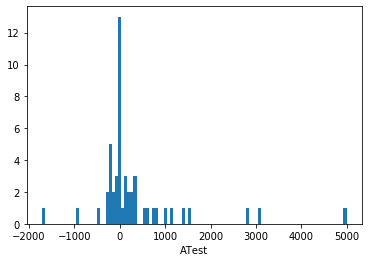

In [32]:
print(f'min: {np.min(init_diff_sector_totals)}')
print(f'max: {np.max(init_diff_sector_totals)}')
plt.hist(init_diff_sector_totals, bins=100)
plt.xlabel("ATest")
plt.show()

In [13]:
init_diff_country_totals = mat_emissions_country_totals - np.nansum(mat_emissions, axis=1)

min: -67.07234080289737
max: 5052.12987737178


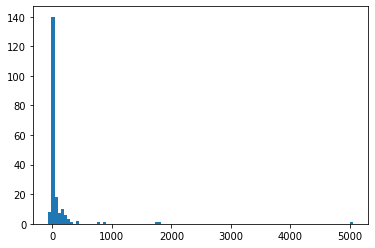

In [29]:
print(f'min: {np.min(init_diff_country_totals)}')
print(f'max: {np.max(init_diff_country_totals)}')
plt.hist(init_diff_country_totals, bins=100)
plt.show()